In [1]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

/home/sarthak/local/vectorvision/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
from datasets import load_dataset
dataset_name = "pouya-haghi/imagenet-subset"
local_path = "data/"
dataset = load_dataset(dataset_name, cache_dir=local_path)
print(f"{dataset_name} downloaded to {local_path}")

pouya-haghi/imagenet-subset downloaded to data/


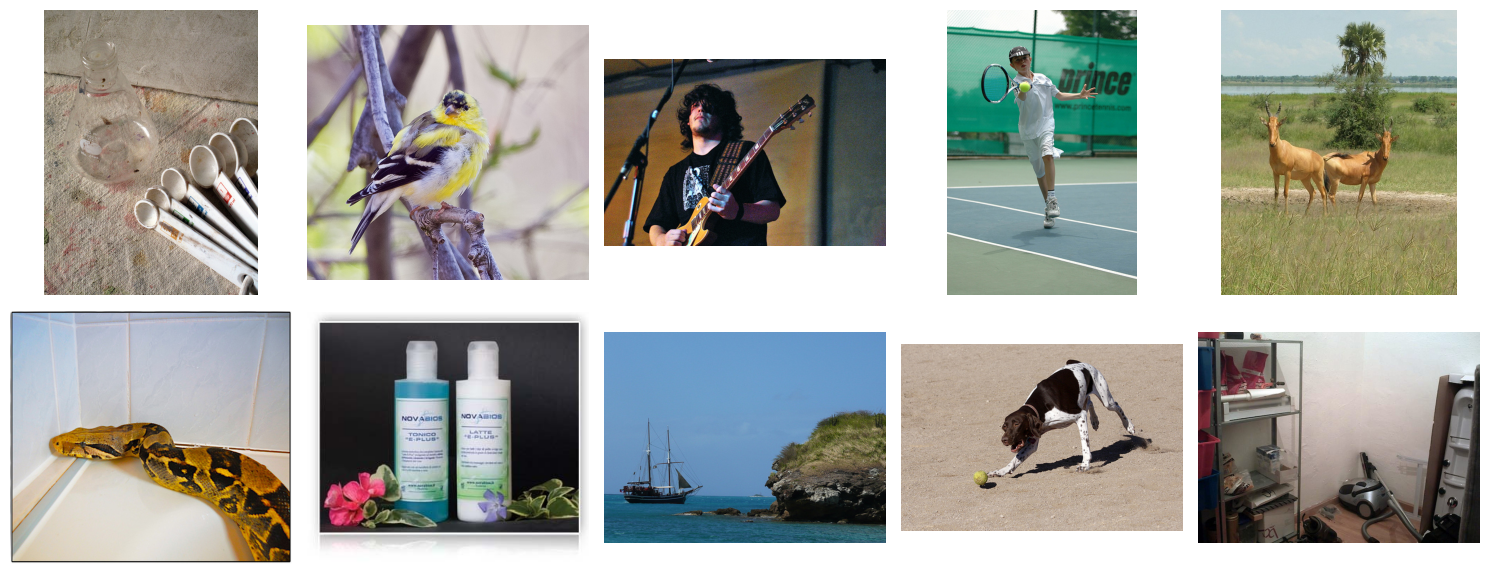

In [3]:
fig, axes = plt.subplots(2, 5, figsize = (15, 6))
random_indices = random.sample(range(len(dataset['validation'])), 10)

for i, ax in enumerate(axes.flat):
    sample = dataset['validation'][random_indices[i]]
    image = sample['img'] if 'img' in sample else sample['image']

    if isinstance(image, Image.Image):
        ax.imshow(image)
    else:
        ax.imshow(Image.fromarray(image))
    
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def generate_clip_embeddings(dataset, model):


    embeddings = []
    indexes = []
    count = 0
    for img in tqdm(dataset['validation']):
        image = img['image']
        indexes.append(count)
        count += 1
        embedding = model.encode(image)
        embeddings.append(embedding)

    return embeddings, indexes


model = SentenceTransformer('clip-ViT-B-32', device='cuda')
embeddings, indexes = generate_clip_embeddings(dataset, model)

/home/sarthak/local/vectorvision/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 6180/6180 [01:35<00:00, 64.90it/s]


In [5]:
def create_faiss_index(embeddings, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # # Save image paths
    # with open(output_path + '.images', 'w') as f:
    #     for img_path in images:
    #         f.write(img_path + '\n')

    return index


OUTPUT_INDEX_PATH = "vector.index"
index = create_faiss_index(embeddings, OUTPUT_INDEX_PATH)

Index created and saved to vector.index


In [6]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    return index

index = load_faiss_index(OUTPUT_INDEX_PATH)

In [7]:
def retrieve_similar_images(query, model, index, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    return query, distances, indices

In [8]:
def visualize_results(query, retrieved_images, distances):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, index in enumerate(retrieved_images[0]):
        plt.subplot(1, len(retrieved_images[0]) + 1, i + start_idx)
        plt.imshow(dataset['validation'][int(index)]['image'])
        plt.title(f"Match {i + 1}")
        plt.axis('off')

        plt.text(
            0.5, -0.15,              # x, y position of the text
            f'Score: {round(float(distances[0][i]), 2)}',
            fontsize=12,             # Font size
            ha='center',             # Horizontal alignment
            va='top',                # Vertical alignment
            transform=plt.gca().transAxes  # Position relative to the axis
        )
    plt.show()

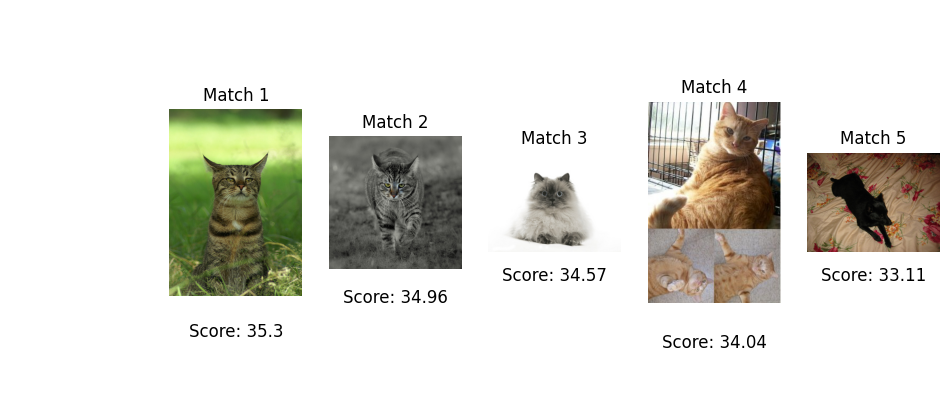

In [9]:
query = 'a cat'
query, distances, indexes = retrieve_similar_images(query, model, index, top_k=5)
visualize_results(query, indexes, distances)

In [10]:
distances

array([[35.298595, 34.96432 , 34.574345, 34.03505 , 33.114994]],
      dtype=float32)